In [1]:
import pandas as pd
import numpy as np

from data.data_dictionary import var_map, chron_conditions

chroncon_file = 'data/Assignment4_ChronicConditions-2.csv'
df = pd.DataFrame.from_csv(chroncon_file, encoding='latin1').reset_index()

display(df.head(2))
print(df.shape)
print(chron_conditions)

,BENE_SEX_IDENT_CD,BENE_AGE_CAT_CD,CC_ALZHDMTA,CC_CANCER,CC_CHF,CC_CHRNKIDN,CC_COPD,CC_DEPRESSN,CC_DIABETES,CC_ISCHMCHT,...,BENE_COUNT_PC_LT_12,AVE_MO_EN_PC_LT_12,BENE_COUNT_PC_EQ_12,BENE_COUNT_PD_LT_12,AVE_MO_EN_PD_LT_12,AVE_PDE_CST_PD_LT_12,AVE_PDE_PD_LT_12,BENE_COUNT_PD_EQ_12,AVE_PDE_CST_PD_EQ_12,AVE_PDE_PD_EQ_12
0,1,1,NaN,NaN,0,0,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,7230.0,49.877
1,1,1,NaN,NaN,0,0,NaN,NaN,0,0,...,NaN,NaN,NaN,42.0,5.952,2165.0,24.81,203.0,7163.0,73.404


(22003, 55)
['CC_NONE', 'CC_STRKETIA', 'CC_RA_OA', 'CC_OSTEOPRS', 'CC_ISCHMCHT', 'CC_CHF', 'CC_DIABETES', 'CC_DEPRESSN', 'CC_COPD', 'CC_CHRNKIDN', 'CC_CANCER', 'CC_ALZHDMTA']


In [2]:
# Columns for total spent for each profile

df['A_tot_pay']      = df['BENE_COUNT_PA_EQ_12'] * df['AVE_PA_PAY_PA_EQ_12']
df['A_tot_IP']       = df['BENE_COUNT_PA_EQ_12'] * df['AVE_IP_PAY_PA_EQ_12']
df['A_tot_IP_adm']   = df['BENE_COUNT_PA_EQ_12'] * df['AVE_IP_ADM_PA_EQ_12']
df['A_tot_SNF']      = df['BENE_COUNT_PA_EQ_12'] * df['AVE_SNF_PAY_PA_EQ_12']
df['A_tot_SNF_days'] = df['BENE_COUNT_PA_EQ_12'] * df['AVE_SNF_DAYS_PA_EQ_12']
df['A_tot_other']    = df['BENE_COUNT_PA_EQ_12'] * df['AVE_OTH_PAY_PA_EQ_12']

df['B_tot_pay']    = df['BENE_COUNT_PB_EQ_12'] * df['AVE_PB_PAY_PB_EQ_12']
df['B_tot_CA']     = df['BENE_COUNT_PB_EQ_12'] * df['AVE_CA_PAY_PB_EQ_12']
df['B_tot_CA_vis'] = df['BENE_COUNT_PB_EQ_12'] * df['AVE_CA_VST_PB_EQ_12']
df['B_tot_OP']     = df['BENE_COUNT_PB_EQ_12'] * df['AVE_OP_PAY_PB_EQ_12']
df['B_tot_OP_vis'] = df['BENE_COUNT_PB_EQ_12'] * df['AVE_OP_VST_PB_EQ_12']
df['B_tot_other']  = df['BENE_COUNT_PB_EQ_12'] * df['AVE_OTH_PAY_PB_EQ_12']

df['D_tot_cost'] = df['BENE_COUNT_PD_EQ_12'] * df['AVE_PDE_CST_PD_EQ_12']
df['D_tot_rx']   = df['BENE_COUNT_PD_EQ_12'] * df['AVE_PDE_PD_EQ_12']


# Column for people with no conditions
df['CC_NONE'] = 0.
df.loc[
    (df.CC_ALZHDMTA == 0.) & 
    (df.CC_CANCER == 0.)   & 
    (df.CC_CHF == 0.)      & 
    (df.CC_CHRNKIDN == 0.) & 
    (df.CC_COPD == 0.)     & 
    (df.CC_DEPRESSN == 0.) & 
    (df.CC_DIABETES == 0.) & 
    (df.CC_ISCHMCHT == 0.) & 
    (df.CC_OSTEOPRS == 0.) & 
    (df.CC_RA_OA == 0.)    & 
    (df.CC_STRKETIA == 0.) ,
    'CC_NONE'] = 1.

In [3]:
## _____________________________________________________________________________
def get_df(df, chroncon, excl=True):
    
    if chroncon == 'CC_NONE':
        df_ = df[df[chroncon] == 1.]
        return df_
        
    # only keep rows where condition IS present - also drops suppressed
    df_ = df[df[chroncon] == 1.]

    if excl:
        # drop rows where other conditions ARE present
        for xc in chron_conditions:
            if xc in [chroncon, 'CC_NONE']: continue
            df_ = df_.drop(df_[df_[xc] == 1.].index)

    return df_

In [4]:
## _____________________________________________________________________________
def build_numbers(df, excl=True, append=True):

    numbers = { x : {} for x in chron_conditions }

    for x in chron_conditions:
        df_ = get_df(df, x, excl)


        numbers[x]['part_A'] = {
            'num_benes'    : 0,
            'tot_pay'      : 0.,
            'avg_pay'      : 0.,
            'avg_IP'       : 0.,
            'avg_IP_adm'   : 0.,
            'avg_SNF'      : 0.,
            'avg_SNF_days' : 0.,
            'avg_other'    : 0.,
        }       

        numbers[x]['part_B'] = {
            'num_benes'   : 0,
            'tot_pay'     : 0.,
            'avg_pay'     : 0.,
            'avg_CA'      : 0.,
            'avg_CA_vis'  : 0.,
            'avg_OP'      : 0.,
            'avg_OP_vis'  : 0.,
            'avg_other'   : 0.,
        }

        numbers[x]['part_C'] = {
            'num_benes' : 0,
        }

        numbers[x]['part_D'] = {
            'num_benes'   : 0,
            'tot_cost'    : 0.,
            'avg_num_rx'  : 0.,
            'avg_rx_cost' : 0.,
        }


        
        # Part A
        #############################
        # Num benes with this condition
        numbers[x]['part_A']['num_benes'] = df_['BENE_COUNT_PA_EQ_12'].sum()

        # Total spent for people with this condition
        numbers[x]['part_A']['tot_pay'] = df_['A_tot_pay'].sum()

        # Average spent per person with this condition
        numbers[x]['part_A']['avg_pay'] = df_['A_tot_pay'].sum() \
                                       / numbers[x]['part_A']['num_benes']

        # Average paid for InPatient services per person with this condition
        numbers[x]['part_A']['avg_IP']  = df_['A_tot_IP'].sum() \
                                       / numbers[x]['part_A']['num_benes']

        # Average InPatient admissions per person with this condition
        numbers[x]['part_A']['avg_IP_adm'] = df_['A_tot_IP_adm'].sum() \
                                       / numbers[x]['part_A']['num_benes']

        # Average paid for Skilled Nursing Facility services per person with this condition
        numbers[x]['part_A']['avg_SNF'] = df_['A_tot_SNF'].sum() \
                                       / numbers[x]['part_A']['num_benes']

        # Average Skilled Nursing Facility covered days per person with this condition
        numbers[x]['part_A']['avg_SNF_days'] = df_['A_tot_SNF_days'].sum() \
                                       / numbers[x]['part_A']['num_benes']

        # Average other spending per person with this condition
        numbers[x]['part_A']['avg_other'] = df_['A_tot_other'].sum() \
                                       / numbers[x]['part_A']['num_benes']


        # Part B
        #############################
        # Num benes with this condition
        numbers[x]['part_B']['num_benes'] = df_['BENE_COUNT_PB_EQ_12'].sum()

        # Total spent for people with this condition
        numbers[x]['part_B']['tot_pay'] = df_['B_tot_pay'].sum()

        # Average spent per person with this condition
        numbers[x]['part_B']['avg_pay'] = df_['B_tot_pay'].sum() \
                                          / numbers[x]['part_B']['num_benes']
        
        # Average spent for Carrier/Physician visits per person with this condition
        numbers[x]['part_B']['avg_CA'] = df_['B_tot_CA'].sum() \
                                          / numbers[x]['part_B']['num_benes']

        # Average Carrier/Physician visits per person with this condition
        numbers[x]['part_B']['avg_CA_vis'] = df_['B_tot_CA_vis'].sum() \
                                          / numbers[x]['part_B']['num_benes']

        # Average spent for OutPatient services per person with this condition
        numbers[x]['part_B']['avg_OP'] = df_['B_tot_OP'].sum() \
                                          / numbers[x]['part_B']['num_benes']

        # Average OutPatient visits per person with this condition
        numbers[x]['part_B']['avg_OP_vis'] = df_['B_tot_OP_vis'].sum() \
                                          / numbers[x]['part_B']['num_benes']

        # Average other spending per person with this condition
        numbers[x]['part_B']['avg_other'] = df_['B_tot_other'].sum() \
                                          / numbers[x]['part_B']['num_benes']


        # Part C
        #############################
        # Num benes with this condition
        numbers[x]['part_C']['num_benes'] = df_['BENE_COUNT_PC_EQ_12'].sum()


        # Part D
        #############################
        # Num benes with this condition
        numbers[x]['part_D']['num_benes'] = df_['BENE_COUNT_PD_EQ_12'].sum()

        # Total spent for people with this condition
        numbers[x]['part_D']['tot_cost'] = df_['D_tot_cost'].sum()
    
        # Average number of RX per person with this condition
        numbers[x]['part_D']['avg_num_rx'] = df_['D_tot_rx'].sum() \
                                      / numbers[x]['part_D']['num_benes']

        # Average RX cost per person with this condition
        numbers[x]['part_D']['avg_rx_cost'] = df_['D_tot_cost'].sum() \
                                          / numbers[x]['part_D']['num_benes']


        scale = 1000000
        if append:
            num_benes_part_A.append(numbers[x]['part_A']['num_benes'])
            tot_paid_part_A.append(numbers[x]['part_A']['tot_pay'] / scale)
            avg_paid_part_A.append(numbers[x]['part_A']['avg_pay'])
            avg_IP_paid_part_A.append(numbers[x]['part_A']['avg_IP'])
            avg_IP_adms_part_A.append(numbers[x]['part_A']['avg_IP_adm'])
            avg_SNF_paid_part_A.append(numbers[x]['part_A']['avg_SNF'])
            avg_SNF_days_part_A.append(numbers[x]['part_A']['avg_SNF_days'])

            num_benes_part_B.append(numbers[x]['part_B']['num_benes'])
            tot_paid_part_B.append(numbers[x]['part_B']['tot_pay'] / scale)
            avg_paid_part_B.append(numbers[x]['part_B']['avg_pay'])
            avg_CA_paid_part_B.append(numbers[x]['part_B']['avg_CA'])
            avg_CA_vis_part_B.append(numbers[x]['part_B']['avg_CA_vis'])
            avg_OP_paid_part_B.append(numbers[x]['part_B']['avg_OP'])
            avg_OP_vis_part_B.append(numbers[x]['part_B']['avg_OP_vis'])
            
            num_benes_part_C.append(numbers[x]['part_C']['num_benes'])
            
            num_benes_part_D.append(numbers[x]['part_D']['num_benes'])
            tot_paid_part_D.append(numbers[x]['part_D']['tot_cost'] / scale)
            avg_num_rx_part_D.append(numbers[x]['part_D']['avg_num_rx'])
            avg_paid_part_D.append(numbers[x]['part_D']['avg_rx_cost'])
            

    del df_
    return numbers

In [5]:
## _____________________________________________________________________________
def print_numbers(chroncon, numbers):

    print(var_map[chroncon] + ':')
    
    n = numbers[chroncon]
    
    print('   ', 'Part A=12:')
    print('       ', 'Num benes with this condition:',
           str(int(n['part_A']['num_benes'])))
    print('       ', 'Total spent for people with this condition:',
           str(n['part_A']['tot_pay']))
    print('       ', 'Average spent per person with this condition:',
           str((n['part_A']['avg_pay'])))
    print('       ', 'Average for InPatient services per person with this condition:',
           str((n['part_A']['avg_IP'])))
    print('       ', 'Average InPatient admissions per person with this condition:',
           str((n['part_A']['avg_IP_adm'])))
    print('       ', 'Average for Skilled Nursing Facility services per person with this condition:',
           str((n['part_A']['avg_SNF'])))
    print('       ', 'Average Skilled Nursing Facility covered days per person with this condition:',
           str((n['part_A']['avg_SNF_days'])))
    print('       ', 'Average other spending per person with this condition:',
           str((n['part_A']['avg_other'])))
    

    print('\n   ', 'Part B=12:')
    print('       ', 'Num benes with this condition:',
           str(int(n['part_B']['num_benes'])))
    print('       ', 'Total spent for people with this condition:',
           str(n['part_B']['tot_pay']))
    print('       ', 'Average spent per person with this condition:',
           str(n['part_B']['avg_pay']))
    print('       ', 'Average for Carrier/Physician visits per person with this condition:',
           str(n['part_B']['avg_CA']))
    print('       ', 'Average Carrier/Physician visits per person with this condition:',
           str(n['part_B']['avg_CA_vis']))
    print('       ', 'Average for OutPatient services per person with this condition:',
           str(n['part_B']['avg_OP']))
    print('       ', 'Average OutPatient visits per person with this condition:',
           str(n['part_B']['avg_OP_vis']))
    print('       ', 'Average other spending per person with this condition:',
           str(n['part_B']['avg_other']))
    
    print('\n   ', 'Part C=12:')
    print('       ', 'Num benes with this condition:',
           str(int(n['part_C']['num_benes'])))
    
    print('\n   ', 'Part D=12:')
    print('       ', 'Num benes with this condition:',
           str(int(n['part_D']['num_benes'])))
    
    print('       ', 'Total spent on RX for people with this condition:',
           str(n['part_D']['tot_cost']))
    
    print('       ', 'Average number of RX per person with this condition:',
           str(n['part_D']['avg_num_rx']))
    
    print('       ', 'Average RX cost per person with this condition:',
           str(n['part_D']['avg_rx_cost']))
    
    print('\n\n\n')

In [6]:
num_benes_part_A = []
num_benes_part_B = []
num_benes_part_C = []
num_benes_part_D = []

tot_paid_part_A = []
tot_paid_part_B = []
tot_paid_part_D = []

avg_paid_part_A = []
avg_paid_part_B = []
avg_paid_part_D = []

avg_IP_adms_part_A  = []
avg_IP_paid_part_A  = []
avg_SNF_days_part_A = []
avg_SNF_paid_part_A = []

avg_CA_vis_part_B  = []
avg_CA_paid_part_B = []
avg_OP_vis_part_B  = []
avg_OP_paid_part_B = []

avg_num_rx_part_D = []

# Start here!

In [7]:
numbers1 = build_numbers(df, excl=True)
for x in reversed(chron_conditions):
    print_numbers(x, numbers1)

Alzheimer's Disease:
    Part A=12:
        Num benes with this condition: 348039
        Total spent for people with this condition: 1066412773.0
        Average spent per person with this condition: 3064.061133953379
        Average for InPatient services per person with this condition: 945.279149750459
        Average InPatient admissions per person with this condition: 0.12434867356819207
        Average for Skilled Nursing Facility services per person with this condition: 482.09908946985826
        Average Skilled Nursing Facility covered days per person with this condition: 1.2430502472424068
        Average other spending per person with this condition: 1636.6828947330616

    Part B=12:
        Num benes with this condition: 345433
        Total spent for people with this condition: 783276634.0
        Average spent per person with this condition: 2267.521151713936
        Average for Carrier/Physician visits per person with this condition: 1170.1593970466054
        Average Ca

## Plots

In [8]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-muted')
plt.rc('axes', axisbelow=True)
%matplotlib inline

con_labels = [ var_map[c] for c in chron_conditions ]
idx = np.arange(len(con_labels))

#### Number of beneficiaries in each program (may overlap)

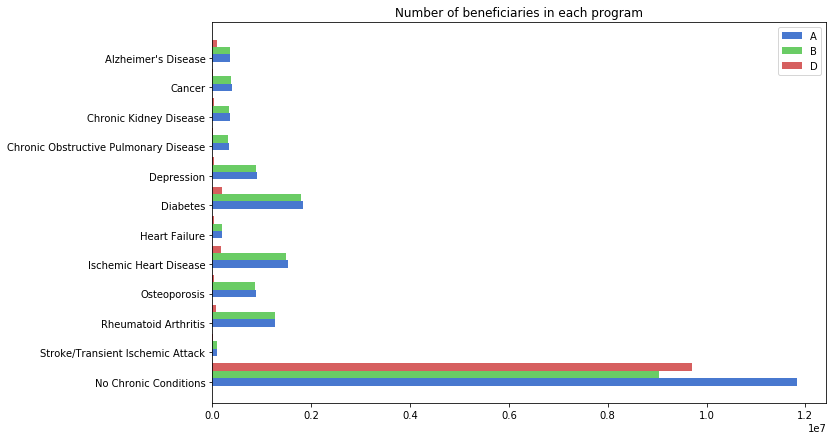

In [9]:
_ = plt.figure(figsize=(11,7))

p1 = plt.barh(idx + 0.00, num_benes_part_A, height = 0.25)
p2 = plt.barh(idx + 0.25, num_benes_part_B, height = 0.25)
p4 = plt.barh(idx + 0.50, num_benes_part_C, height = 0.25)

plt.title('Number of beneficiaries in each program')
plt.yticks(idx, con_labels)
plt.legend((p1[0], p2[0], p4[0]), ('A', 'B', 'D'))
plt.show();

#### Same as above but without 'no conditions' category

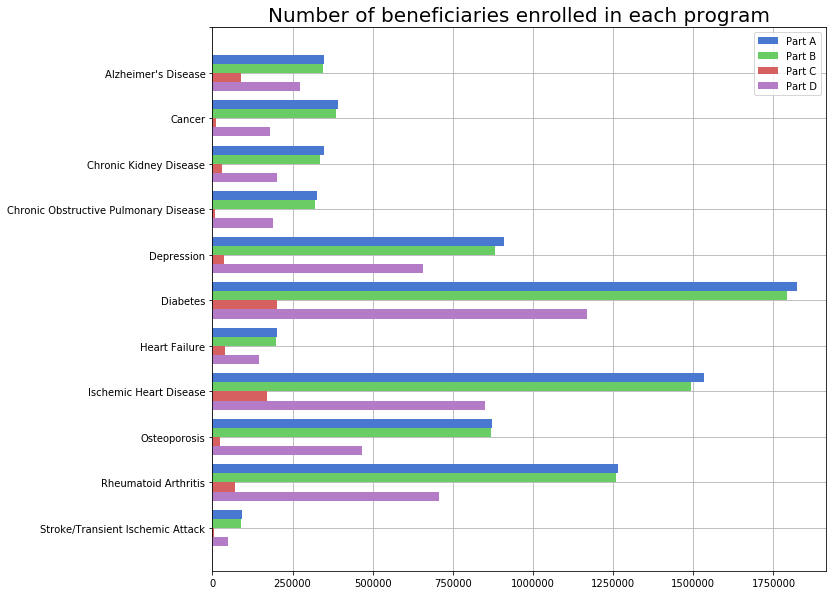

In [10]:
fig, ax = plt.subplots(1,1,figsize=(11,10));

p1 = plt.barh(idx[:-1] + 0.3, num_benes_part_A[1:], height = 0.2)
p2 = plt.barh(idx[:-1] + 0.1, num_benes_part_B[1:], height = 0.2)
p3 = plt.barh(idx[:-1] - 0.1, num_benes_part_C[1:], height = 0.2)
p4 = plt.barh(idx[:-1] - 0.3, num_benes_part_D[1:], height = 0.2)

ax.grid();

plt.title('Number of beneficiaries enrolled in each program', fontsize=20)
plt.yticks(idx, con_labels[1:])
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Part A', 'Part B', 'Part C', 'Part D'))
plt.show();

#### Same as above but in a different order

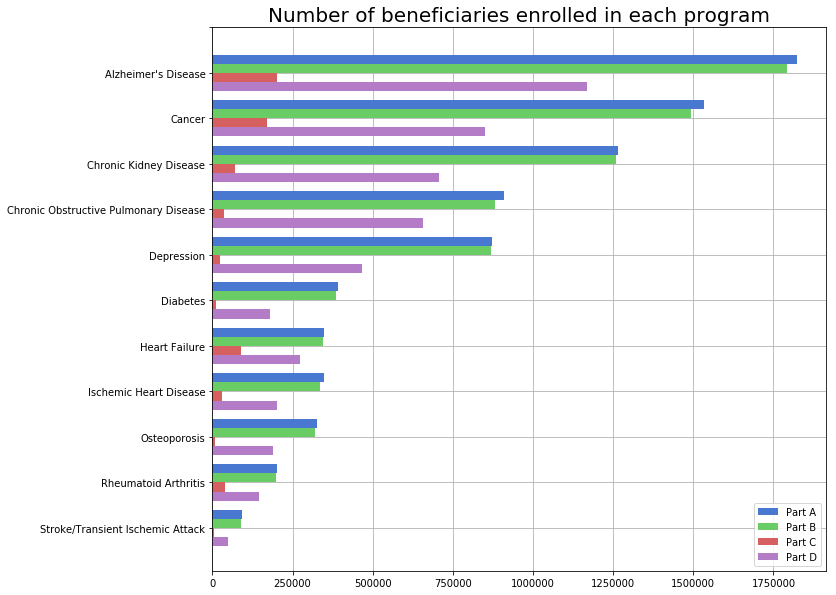

In [11]:
order = [
    'CC_STRKETIA',
    'CC_CHF',
    'CC_COPD',
    'CC_CHRNKIDN',
    'CC_ALZHDMTA',
    'CC_CANCER',
    'CC_OSTEOPRS',
    'CC_DEPRESSN',
    'CC_RA_OA',
    'CC_ISCHMCHT',
    'CC_DIABETES',
]

part_a_ordered = [ numbers1[x]['part_A']['num_benes'] for x in order ]
part_b_ordered = [ numbers1[x]['part_B']['num_benes'] for x in order ]
part_c_ordered = [ numbers1[x]['part_C']['num_benes'] for x in order ]
part_d_ordered = [ numbers1[x]['part_D']['num_benes'] for x in order ]

fig, ax = plt.subplots(1,1,figsize=(11,10));

p1 = plt.barh(idx[:-1] + 0.3, part_a_ordered, height = 0.2)
p2 = plt.barh(idx[:-1] + 0.1, part_b_ordered, height = 0.2)
p3 = plt.barh(idx[:-1] - 0.1, part_c_ordered, height = 0.2)
p4 = plt.barh(idx[:-1] - 0.3, part_d_ordered, height = 0.2)

ax.grid();

plt.title('Number of beneficiaries enrolled in each program', fontsize=20)
plt.yticks(idx, con_labels[1:])
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Part A', 'Part B', 'Part C', 'Part D'))
plt.show();

#### Total amount spent by condition and program

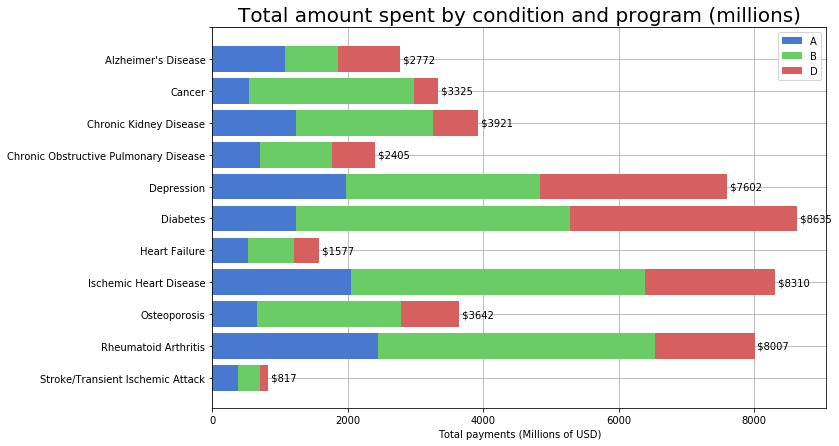

In [12]:
fig, ax = plt.subplots(1,1,figsize=(11,7));

left_A = None
left_B = tot_paid_part_A[1:]
left_D = [sum(x) for x in zip(tot_paid_part_A[1:], tot_paid_part_B[1:])]

p1 = plt.barh(idx[:-1], tot_paid_part_A[1:])
p2 = plt.barh(idx[:-1], tot_paid_part_B[1:], left=left_B)
p4 = plt.barh(idx[:-1], tot_paid_part_D[1:], left=left_D)

ax.grid();

plt.title('Total amount spent by condition and program (millions)', fontsize=20)
plt.yticks(idx, con_labels[1:])
plt.xlabel('Total payments (Millions of USD)')
for i,v in enumerate(chron_conditions[1:]):
    v = int((tot_paid_part_A[i+1] + tot_paid_part_B[i+1] + tot_paid_part_D[i+1])) 
    plt.text(v, i, ' ' + '${0}'.format(v), va='center', color='black')#, fontweight='bold')
plt.legend((p1[0], p2[0], p4[0]), ('A', 'B', 'D'))
plt.show();

#### Average amount spent per beneficiary by condition and program

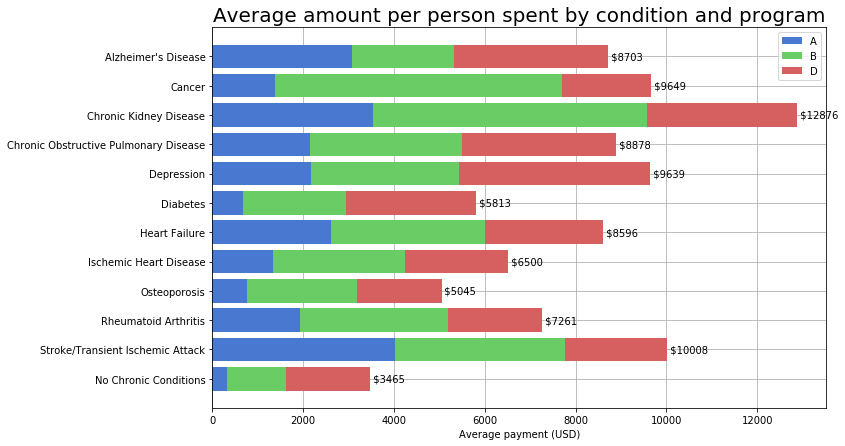

In [13]:
fig, ax = plt.subplots(1,1,figsize=(11,7));

left_A = None
left_B = avg_paid_part_A
left_D = [sum(x) for x in zip(avg_paid_part_A, avg_paid_part_B)]

ax.grid();

p1 = plt.barh(idx, avg_paid_part_A)
p2 = plt.barh(idx, avg_paid_part_B, left=left_B)
p4 = plt.barh(idx, avg_paid_part_D, left=left_D)

plt.title('Average amount per person spent by condition and program', fontsize=20)
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = int((avg_paid_part_A[i] + avg_paid_part_B[i] + avg_paid_part_D[i])) 
    plt.text(v, i, ' ' + '${0}'.format(v), va='center', color='black')#, fontweight='bold')
plt.xlabel('Average payment (USD)')

plt.legend((p1[0], p2[0], p4[0]), ('A', 'B', 'D'))

plt.show();

### MEDICARE PART A

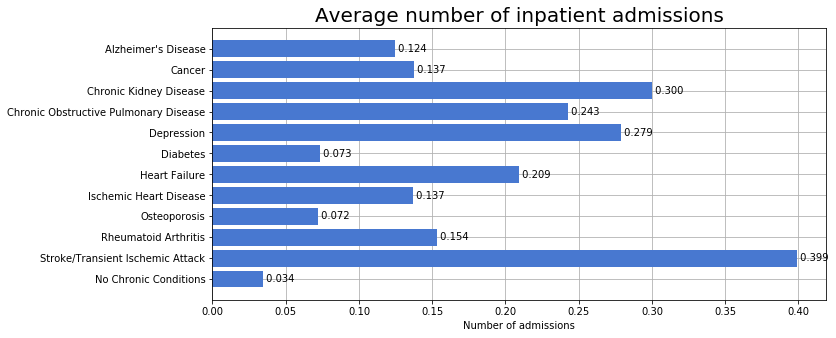

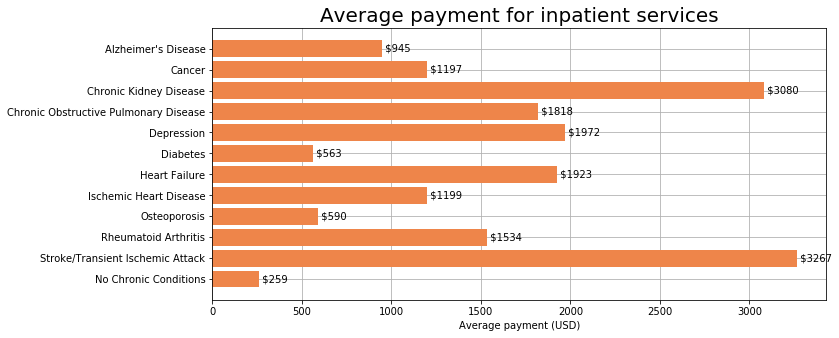

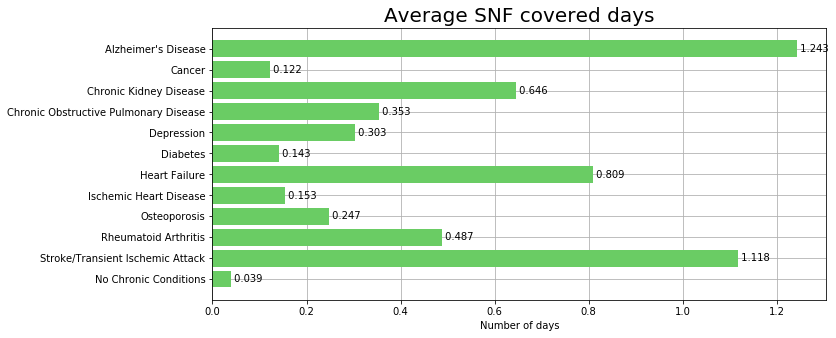

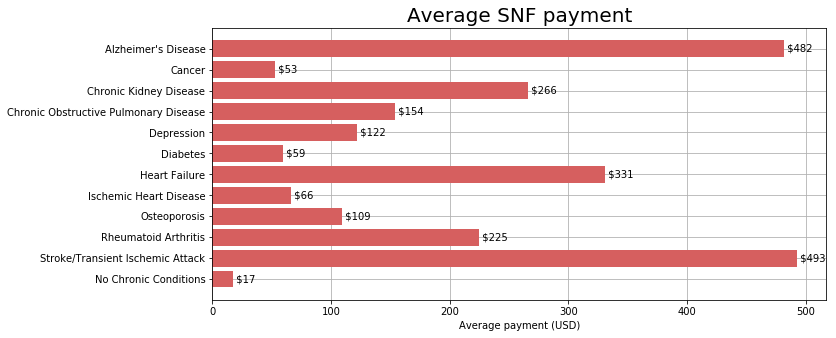

In [14]:
fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_IP_adms_part_A, color='#4878D0');
plt.title('Average number of inpatient admissions', fontsize=20)
ax.grid();
plt.xlabel('Number of admissions')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_IP_adms_part_A[i]
    plt.text(v, i, ' ' + '{0:.3f}'.format(v), va='center')
plt.show();

fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_IP_paid_part_A, color='#EE854A')
plt.title('Average payment for inpatient services', fontsize=20)
ax.grid();
plt.xlabel('Average payment (USD)')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_IP_paid_part_A[i]
    plt.text(v, i, ' ' + '${0:.0f}'.format(v), va='center')
plt.show();

fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_SNF_days_part_A, color='#6ACC64')
plt.title('Average SNF covered days', fontsize=20)
ax.grid();
plt.xlabel('Number of days')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_SNF_days_part_A[i]
    plt.text(v, i, ' ' + '{0:.3f}'.format(v), va='center')
plt.show();

fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_SNF_paid_part_A, color='#D65F5F')
plt.title('Average SNF payment', fontsize=20)
ax.grid();
plt.xlabel('Average payment (USD)')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_SNF_paid_part_A[i]
    plt.text(v, i, ' ' + '${0:.0f}'.format(v), va='center')
plt.show();

### MEDICARE PART B

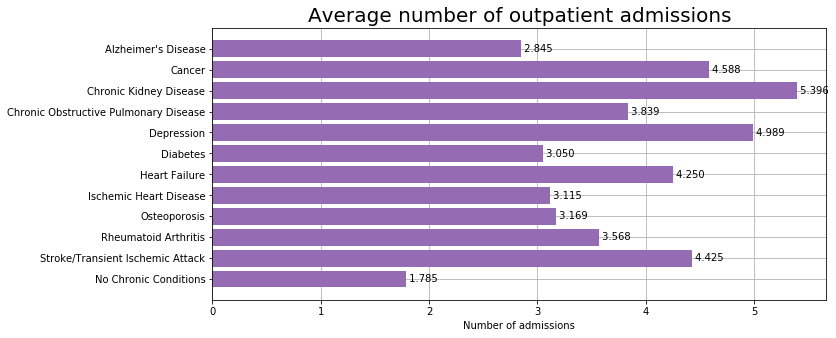

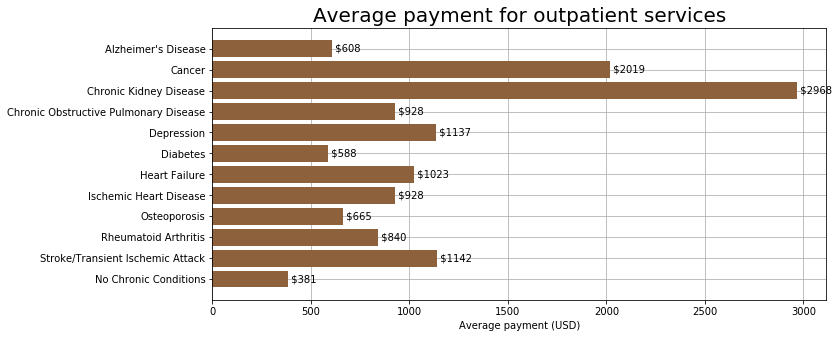

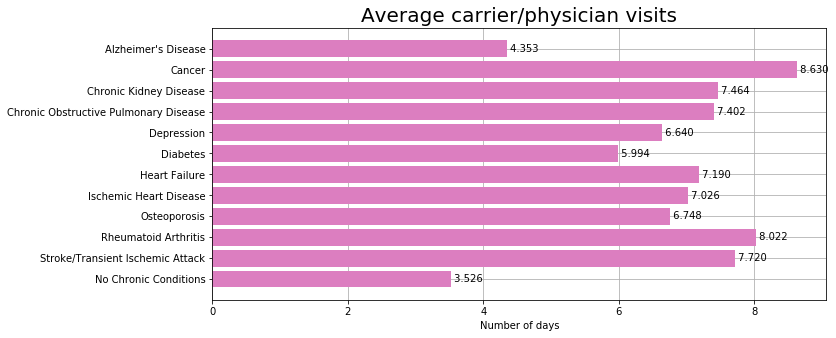

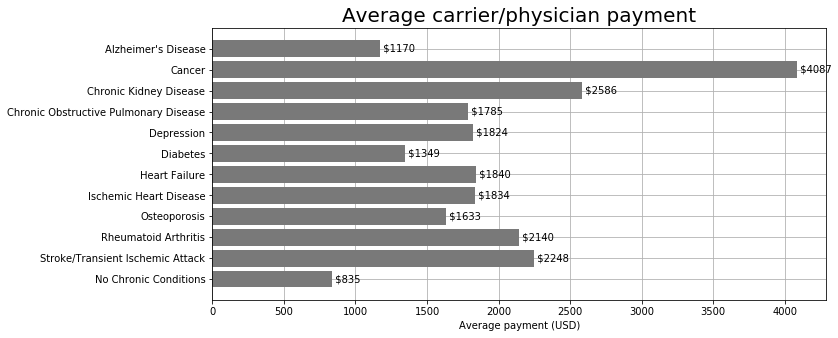

In [15]:
fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_OP_vis_part_B, color='#956CB4');
plt.title('Average number of outpatient admissions', fontsize=20)
ax.grid();
plt.xlabel('Number of admissions')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_OP_vis_part_B[i]
    plt.text(v, i, ' ' + '{0:.3f}'.format(v), va='center')
plt.show();

fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_OP_paid_part_B, color='#8C613C')
plt.title('Average payment for outpatient services', fontsize=20)
ax.grid();
plt.xlabel('Average payment (USD)')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_OP_paid_part_B[i]
    plt.text(v, i, ' ' + '${0:.0f}'.format(v), va='center')
plt.show();

fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_CA_vis_part_B, color='#DC7EC0')
plt.title('Average carrier/physician visits', fontsize=20)
ax.grid();
plt.xlabel('Number of days')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_CA_vis_part_B[i]
    plt.text(v, i, ' ' + '{0:.3f}'.format(v), va='center')
plt.show();

fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_CA_paid_part_B, color='#797979')
plt.title('Average carrier/physician payment', fontsize=20)
ax.grid();
plt.xlabel('Average payment (USD)')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_CA_paid_part_B[i]
    plt.text(v, i, ' ' + '${0:.0f}'.format(v), va='center')#, fontweight='bold')
plt.show();

### MEDICARE PART D

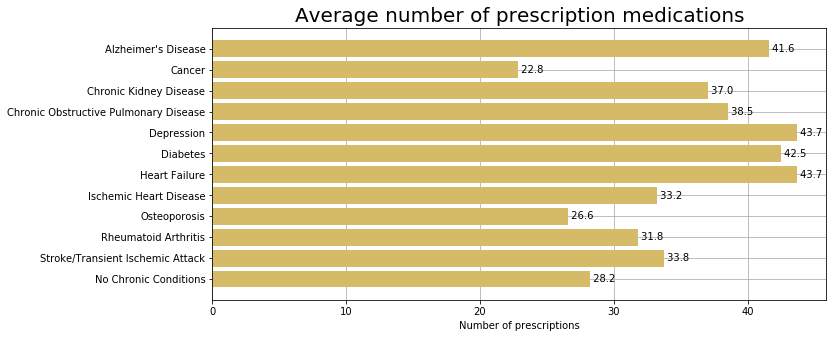

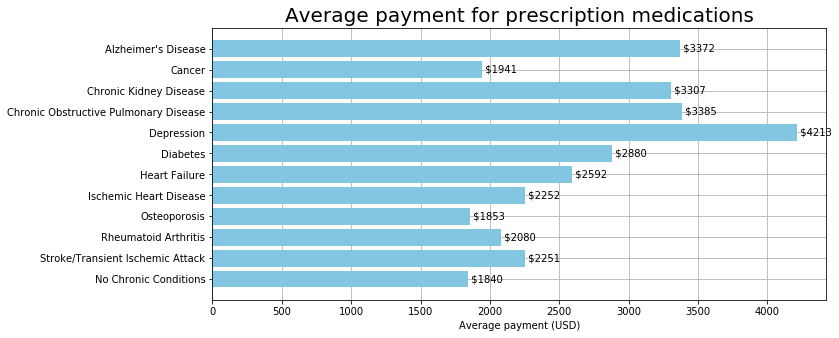

In [16]:
fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_num_rx_part_D, color='#D5BB67');
plt.title('Average number of prescription medications', fontsize=20)
ax.grid();
plt.xlabel('Number of prescriptions')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_num_rx_part_D[i]
    plt.text(v, i, ' ' + '{0:.1f}'.format(v), va='center')
plt.show();

fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_paid_part_D, color='#82C6E2')
plt.title('Average payment for prescription medications', fontsize=20)
ax.grid();
plt.xlabel('Average payment (USD)')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_paid_part_D[i]
    plt.text(v, i, ' ' + '${0:.0f}'.format(v), va='center')
plt.show();

## Prevalence - Number of beneficiaries with chronic conditions

In [17]:
from tabulate import tabulate

numbers_incl = build_numbers(df, excl=False, append=False)
numbers_excl = build_numbers(df, excl=True, append=False)
headers = ['Condition', 'ONLY this condition', 'AT LEAST this condition']
# Part A
table_A = [[ var_map[x], int(numbers_excl[x]['part_A']['num_benes']), 
          int(numbers_incl[x]['part_A']['num_benes'])] for x in chron_conditions ]
# Part B
table_B = [[ var_map[x], int(numbers_excl[x]['part_B']['num_benes']), 
          int(numbers_incl[x]['part_B']['num_benes'])] for x in chron_conditions ]
# Part C
table_C = [[ var_map[x], int(numbers_excl[x]['part_C']['num_benes']), 
          int(numbers_incl[x]['part_C']['num_benes'])] for x in chron_conditions ]
# Part D
table_D = [[ var_map[x], int(numbers_excl[x]['part_D']['num_benes']), 
          int(numbers_incl[x]['part_D']['num_benes'])] for x in chron_conditions ]


print('*'*87)
print('PART A')
print(tabulate(table_A, headers=headers))
print('*'*87)
print()

print('*'*87)
print('PART B')
print(tabulate(table_B, headers=headers))
print('*'*87)
print()

print('*'*87)
print('PART C')
print(tabulate(table_C, headers=headers))
print('*'*87)
print()

print('*'*87)
print('PART D')
print(tabulate(table_D, headers=headers))
print('*'*87)
print()

***************************************************************************************
PART A
Condition                                ONLY this condition    AT LEAST this condition
-------------------------------------  ---------------------  -------------------------
No Chronic Conditions                               11831235                   11831235
Stroke/Transient Ischemic Attack                       92513                    1031451
Rheumatoid Arthritis                                 1265101                    6406124
Osteoporosis                                          871996                    3709781
Ischemic Heart Disease                               1532862                    9169942
Heart Failure                                         202733                    4422101
Diabetes                                             1823526                    8279240
Depression                                            909324                    4169317
Chronic Obstructive Pulmo